In [1]:
library(survival)
library(reshape2)
library(tibble)
library(xtable)

## Plotting
library(ggplot2)
library(cowplot)
library(pROC)

# library(RColorBrewer)
# library(rgl)
# library(pheatmap)
# library(VennDiagram)
# library(UpSetR)
# library(Rtsne)
# library(dendextend)
# library(repr)
# options(repr.plot.width=8, repr.plot.height=4)

theme_set(theme_bw())

## Custom
source("../functions.R")


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# FUNCTIONS ---------------------------------------------------------------
#' @param y_true numeric vector of true labels with 1 as positive
calc_accuracy <- function(y_true, y_pred) {
  sum(y_pred == y_true) / length(y_true)
}
#' @param y_true numeric vector of true labels with 1 as positive
calc_sensitivity <- function(y_true, y_pred) {
  sum(y_pred[y_true == 1] == 1) / sum(y_true == 1)
}
#' @param y_true numeric vector of true labels with 1 as positive
calc_specificity <- function(y_true, y_pred) {
  sum(y_pred[y_true == 0] == 0) / sum(y_true == 0)
}

#' Sorts sample IDs so that they are paired
sort_sid <- function(x) {
  pid <- sapply(x, substring, 1, 4)
  time <- sapply(x, substring, 6, 7)
  time_pid <- mapply(paste0, time, pid)
  return(x[order(time_pid)])
}

#' Boolean function checking that dataframe provided has matching pair names
#' @param X dataframe with paired samples
#' @return logical indicating if it is paired or not
is_paired <- function(x) {
  #' @param character of sample ids
  #' @return logical indicating if it is paired or not
  .is_paired <- function(sid) {
    n <- length(sid)
    pid <- substring(sid, 1, 4)
    all(pid[1:(n / 2)] == pid[(n / 2 + 1):n])
  }
  
  if (is.data.frame(x) | is.matrix(x)) {
    return(.is_paired(colnames(x)))
  } else if (is.character(x)) {
    return(.is_paired(x))
  } else{
    stop("x is not a dataframe, matrix or character.")
  }
}

In [3]:
 #' @param response_df dataframe with samples x features
#' @param normal_df dataframe with samples x features
# D0 centroid used to define D0-Normal vector
compute_features <- function(
  response_df, normal_df,
  sid_train, sid_remission
) {
  print(rownames(response_df))
  # Split response df into D0 and D8 df
  n <- nrow(response_df)/2
  d0_df <- response_df[1:n, , drop = F]
  d8_df <- response_df[-(1:n), , drop = F]
  
  if (!is_paired(t(response_df)))
    stop("Patient IDs are not paired..")
  
  # Calculate centroids
  # Only use remission patients in training set to calculate centroid
  sid_leuk <- Reduce(
    intersect,
    list(rownames(d0_df), sid_train, sid_remission)
  )
  print(rownames(d0_df))
  print(sprintf("NO. OF SAMPLES IN CENTROID: %d", length(sid_leuk)))
  leuk_centroid <- apply(d0_df[sid_leuk, , drop = F], 2, median)
  normal_centroid <- apply(normal_df, 2, median)
  
  # Calculate leuk-normal unit vector
  leuk_normal <- normal_centroid - leuk_centroid
  unit_leuk_normal <- leuk_normal/calcL2Norm(leuk_normal)
  
  # Assume that patients from top rows match correspondingly with bottom rows
  # Calculate vector by: D8-D0
  d0_d8_hstack <- d8_df - d0_df
  # Multiplication of erm_factor is propagated through every column
  ### ERM1 ###
  erm1 <- colSums(t(d0_d8_hstack) * unit_leuk_normal)
  # Vertical stack of individual D0-Normal vectors
  d0_normal_vstack <- normal_centroid - t(d0_df)
  ### D0-Normal projection ###
  d0_normal_proj <- colSums(d0_normal_vstack * unit_leuk_normal)
  ### ERM1 Ratio ###
  ## ERM1 / projection of D0-N on L-N
  erm1_ratio1 <- erm1/d0_normal_proj
  
  d8_normal_vstack <- normal_centroid - t(d8_df)
  ### D8-Normal projection ###
  d8_normal_proj <- colSums(d8_normal_vstack * unit_leuk_normal)
  
  stopifnot(identical(names(erm1), names(erm1_ratio1)))
  
  # Calculate vstack of unit D0-Normal vectors
  l2norm_d0_normal <- apply(d0_normal_vstack, 2, calcL2Norm)
  unit_d0_normal_vstack <- sweep(d0_normal_vstack, 2, l2norm_d0_normal, "/")
  
  ### ERM2 ###
  ## Projection of D0-D8 on D0-N
  erm2 <- colSums(t(d0_d8_hstack) * unit_d0_normal_vstack)
  erm2_ratio <- erm2/l2norm_d0_normal
  
  stopifnot(identical(names(erm2), names(erm2_ratio)))
  
  ### ERM3 ###
  ## Along a chosen PC that represents timepoint
  PC <- 1
  # Be careful of direction of D0-N (may be negative)
  # If negative, a larger shift will lead to a smaller ERM3
  dir <- sign(median(normal_df[,PC]) - median(d0_df[,PC]))
  erm3 <- (d8_df[,PC] - d0_df[,PC]) * dir # direction is normalised
  # Divide by D0-Normal along PC
  erm3_ratio <- erm3/(median(normal_df[,PC]) - d0_df[,PC])
  
  stopifnot(identical(names(erm3), names(erm3_ratio)))
  
  ### l2norm ###
  l2norm_d0_d8 <- apply(d0_d8_hstack, 1, calcL2Norm)
  l2norm_d0 <- apply(d0_df, 1, calcL2Norm)
  l2norm_d8 <- apply(d8_df, 1, calcL2Norm)
  diff_l2norm <- l2norm_d8 - l2norm_d0
  
  ### Angle between D0-D8 and Leuk-Normal ###
  angle_d0d8_normal <- apply(
    d0_d8_hstack, 1, function(row_vec) calcAngleVectors(row_vec, leuk_normal)
  )
  
  ### Angle between D0-D8 and D0-Normal ###
  angle_d0d8_d0normal <- mapply(calcAngleVectors,
                                data.frame(t(d0_d8_hstack)),
                                data.frame(d0_normal_vstack))
  
  ### Angle between D0 and D8 ###
  angle_d0_d8 <- mapply(calcAngleVectors,
                        data.frame(t(d0_df)), data.frame(t(d8_df)))
  
  ### Angle between D0 and normal ###
  angle_d0_normal <- apply(
    d0_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between D8 and Normal ###
  angle_d8_normal <- apply(
    d8_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between N-D0 and N-D8 ###
  # Equivalent to angle between D0-N and D8-N
  angle_nd0_nd8 <- mapply(calcAngleVectors,
                          data.frame(d0_normal_vstack),
                          data.frame(d8_normal_vstack))
  
  ### Angle between N-centroid(D0) N-D8 ###
  # Equivalent to angle between centroid(D0)-N and D8-N
  angle_nl_nd8 <- sapply(data.frame(d8_normal_vstack),
                         function(x, y) calcAngleVectors(x, y),
                         leuk_normal)
  
  ### L2-norm between D8 and Normal ###
  l2norm_d8_normal <- apply(d8_normal_vstack, 2, calcL2Norm)
  
  ### L2-norm ratios
  l2norm_ratio1 <- l2norm_d0_d8/l2norm_d0_normal
  l2norm_ratio2 <- l2norm_d0_d8/l2norm_d8_normal
  l2norm_diff <- l2norm_d0_normal - l2norm_d8_normal
  l2norm_diff_ratio <- l2norm_diff/l2norm_d0_d8
  
  ### Ratios
  erm1_ratio2 <- erm1/abs(d8_normal_proj)
  erm1_ratio3 <- erm1/l2norm_d0_d8
  
  ### Concatenate all features ###
  features_df <- data.frame(
    erm1, erm1_ratio1, erm2, erm2_ratio, erm3, erm3_ratio,
    d0_normal_proj, d8_normal_proj, l2norm_d0_d8,
    diff_l2norm, angle_d0_d8, angle_nd0_nd8, angle_nl_nd8,
    angle_d0d8_normal, angle_d0d8_d0normal,
    angle_d0_normal, angle_d8_normal,
    l2norm_d0_normal, l2norm_d8_normal,
    l2norm_ratio1, l2norm_ratio2,
    l2norm_diff, l2norm_diff_ratio,
    erm1_ratio2, erm1_ratio3
  )
  
  rownames(features_df) <- substring(rownames(features_df), 1, 4)
  return(features_df)
}

## Import data

In [4]:
### Metadata ###
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
BATCH_RPATH <- "data/GSE67684/processed/metadata/metadata-batch.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/pid-mrd_label_tte_subtype.tsv"

sid_annot <- read.table(METADATA_RPATH, sep = "\t")
sid_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


### Commonly used globals

In [5]:
COL_LABEL <- c("darkolivegreen3", "tomato3")

Y <- metadata_df[colnames(data),]
Y_annot <- Y[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

# List subtypes
subtypes9 <- levels(metadata_df$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)

#### All train set (incl. hyperdiploid, others)
- For feature investigation. Remove hypodiploid
- Not required in code!

#### All train set (excl. hyperdiploid, others)
- Does not contain heterogeneous subtypes and MRD NA samples

#### Train/test split (excl. hyperdiploid, others)
- Test set does not contain heterogeneous subtypes and MRD NA samples
- Training set should have the same distribution as test set

In [6]:
## Define train/test split
sid_mrd_na <- rownames(yeoh_label)[is.na(yeoh_label$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(Y)[
  !(Y$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(Y) %in% sid_mrd_na)
]
sid_alltrain <- rownames(Y)[
  !(Y$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(Y) %in% sid_mrd_na)
]
sid_train <- rownames(Y)[
  Y$batch_info %in% 1:7 &
  !(Y$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(Y) %in% sid_mrd_na)
]
sid_test <- rownames(Y)[
  Y$batch_info %in% 8:10 &
  !(Y$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(Y) %in% sid_mrd_na)
]

sid_remission <- rownames(Y)[Y$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

### Train/test split: Patients distribution

In [7]:
# TODO: Do not evaluate to heterogeneous subtypes
train_distr <- table(
  Y[sid_train, "subtype"],
  Y[sid_train, "label"]
)/2
test_distr <- table(
  Y[sid_test, "subtype"],
  Y[sid_test, "label"]
)/2

# # Transfer all relapse samples to test set
# test_distr[, 2]<- test_distr[, 2] + train_distr[, 2]
# train_distr[, 2] <- 0

# print(xtable(train_distr, display = rep("d", 3)))
# print(xtable(test_distr, display = rep("d", 3)))

### Subtype-specific models: Predictions

In [54]:
m1_p_alltrain <- read.table("tmp/m1-p_alltrain.tsv", sep = "\t")
m1_p_train <- read.table("tmp/m1-p_train.tsv", sep = "\t")
m1_p_test <- read.table("tmp/m1-p_test.tsv", sep = "\t")

In [55]:
m1a_p_alltrain <- read.table("tmp/m1_wo_mrd-p_alltrain.tsv", sep = "\t")
m1a_p_train <- read.table("tmp/m1_wo_mrd-p_train.tsv", sep = "\t")
m1a_p_test <- read.table("tmp/m1_wo_mrd-p_test.tsv", sep = "\t")

### Yeoh (2018): Global ERM
- Feature selection: Top 1000 DE probesets (Wilcoxon signed-rank test)
- Calculation of ERM on subspace (no PCA)
- Quantile normalisation does not improve results by much

#### All train (w/o Hyper, Others)

In [9]:
## Feature selection
X <- data[, sid_alltrain]
n <- ncol(X)
D0 <- X[, 1:(n / 2)]
D8 <- X[, (n / 2 + 1):n]

if (!is_paired(cbind(D0, D8)))
  stop("Patient IDs are not paired..")

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

wilcox_pvalue <- row_wilcox(D0, D8)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

response <- t(cbind(D0, D8)[ps_wilcox, ])
normal <- t(data[ps_wilcox, sid_normal])
V <- compute_features(response, normal, sid_train, sid_remission)
global_erm_alltrain <- V[, "erm1", drop = F]

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


  [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P010_D0" "P012_D0"
  [8] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [15] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
 [22] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
 [29] "P049_D0" "P050_D0" "P051_D0" "P053_D0" "P054_D0" "P055_D0" "P056_D0"
 [36] "P057_D0" "P058_D0" "P094_D0" "P099_D0" "P102_D0" "P103_D0" "P106_D0"
 [43] "P116_D0" "P120_D0" "P121_D0" "P122_D0" "P127_D0" "P131_D0" "P134_D0"
 [50] "P135_D0" "P136_D0" "P137_D0" "P145_D0" "P147_D0" "P151_D0" "P152_D0"
 [57] "P156_D0" "P160_D0" "P161_D0" "P165_D0" "P166_D0" "P167_D0" "P170_D0"
 [64] "P172_D0" "P175_D0" "P184_D0" "P211_D0" "P001_D8" "P004_D8" "P005_D8"
 [71] "P007_D8" "P008_D8" "P010_D8" "P012_D8" "P013_D8" "P014_D8" "P015_D8"
 [78] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P022_D8" "P023_D8" "P024_D8"
 [85] "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8" "P032_D8"
 [92] "P033_

### Global ERM: Test data 2 (wo Hyper, Others)

In [9]:
X_train <- data[, sid_train]
n <- ncol(X_train)
D0_train <- X_train[, 1:(n / 2)]
D8_train <- X_train[, (n / 2 + 1):n]

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

if (!is_paired(cbind(D0_train, D8_train)))
  stop("Patient IDs are not paired..")
## Feature selection (on training set only) without hyperdiploid, others!
wilcox_pvalue <- row_wilcox(D0_train, D8_train)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

# Subsetting features
response <- t(data[
  ps_wilcox, sort_sid(union(sid_train, sid_test))
])
normal <- t(data[ps_wilcox, sid_normal])

V <- compute_features(response, normal, sid_train, sid_remission)
global_erm_train <- V[
  unique(substring(sid_train, 1, 4)), # subset train samples
  "erm1", drop = F
]
global_erm_test <- V[
  unique(substring(sid_test, 1, 4)), # subset test samples
  "erm1", drop = F
]

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):


  [1] "P001_D0" "P004_D0" "P005_D0" "P007_D0" "P008_D0" "P010_D0" "P012_D0"
  [8] "P013_D0" "P014_D0" "P015_D0" "P016_D0" "P017_D0" "P018_D0" "P019_D0"
 [15] "P022_D0" "P023_D0" "P024_D0" "P025_D0" "P026_D0" "P027_D0" "P028_D0"
 [22] "P029_D0" "P031_D0" "P032_D0" "P033_D0" "P034_D0" "P035_D0" "P036_D0"
 [29] "P049_D0" "P050_D0" "P051_D0" "P053_D0" "P054_D0" "P055_D0" "P056_D0"
 [36] "P057_D0" "P058_D0" "P094_D0" "P099_D0" "P102_D0" "P103_D0" "P106_D0"
 [43] "P116_D0" "P120_D0" "P121_D0" "P122_D0" "P127_D0" "P131_D0" "P134_D0"
 [50] "P135_D0" "P136_D0" "P137_D0" "P145_D0" "P147_D0" "P151_D0" "P152_D0"
 [57] "P156_D0" "P160_D0" "P161_D0" "P165_D0" "P166_D0" "P167_D0" "P170_D0"
 [64] "P172_D0" "P175_D0" "P184_D0" "P211_D0" "P001_D8" "P004_D8" "P005_D8"
 [71] "P007_D8" "P008_D8" "P010_D8" "P012_D8" "P013_D8" "P014_D8" "P015_D8"
 [78] "P016_D8" "P017_D8" "P018_D8" "P019_D8" "P022_D8" "P023_D8" "P024_D8"
 [85] "P025_D8" "P026_D8" "P027_D8" "P028_D8" "P029_D8" "P031_D8" "P032_D8"
 [92] "P033_

### Kang et al. (2010)

In [10]:
log_scaled_data <- log2_transform(scaled_yeoh)
KANG_RPATH <- "data/other_methods/kang_2010-ps.txt"
kang_ps <- readLines(con = KANG_RPATH)

kang_idx <- kang_ps[kang_ps %in% rownames(raw_yeoh)] # 26 probesets
# Select probesets
data_kang <- log_scaled_data[kang_idx, ]

In [11]:
# Subset n = 67 patients
sid_alltrain_d0 <- sid_alltrain[endsWith(sid_alltrain, "_D0")]
d0_kang_alltrain <- data_kang[, sid_alltrain_d0]
colnames(d0_kang_alltrain) <- substring(colnames(d0_kang_alltrain), 1, 4)

# PCA
d0_kang_pca <- prcomp(t(d0_kang_alltrain), center = T, scale. = T)$x
# Survival data
surv_kang <- yeoh_label[
  substring(sid_alltrain_d0, 1, 4),
  c("event_code", "years")
]
kang_alltrain <- cbind(surv_kang, PC1 = d0_kang_pca[, 1])

# Cox PH model
cox_kang <- coxph(
  Surv(years, event_code != 0) ~ PC1,
  data = kang_alltrain
)

# i.e. surv_kang$PC1 * -0.20986
kang_y_alltrain <- predict(cox_kang, newdata = kang_alltrain, type = "lp")

#### Test set

In [12]:
sid_train_d0 <- sid_train[endsWith(sid_train, "_D0")]
kang_train <- data_kang[, sid_train_d0]
colnames(kang_train) <- substring(colnames(kang_train), 1, 4)

sid_test_d0 <- sid_test[endsWith(sid_test, "_D0")]
kang_test <- data_kang[, sid_test_d0]
colnames(kang_test) <- substring(colnames(kang_test), 1, 4)

# PCA
kang_train_pca_obj <- prcomp(t(kang_train), center = T, scale. = T)
kang_train_pca <- kang_train_pca_obj$x
# Survival data
surv_kang <- yeoh_label[
  substring(sid_train_d0, 1, 4),
  c("event_code", "years")
]
surv_pc1_train <- cbind(surv_kang, PC1 = kang_train_pca[, 1])

# Cox PH model
cox_kang <- coxph(
  Surv(years, event_code != 0) ~ PC1,
  data = surv_pc1_train
)
# Train set predictions
kang_y_train <- predict(cox_kang, newdata = surv_pc1_train, type = "lp")

# PCA (project)
kang_test_pca <- predict(kang_train_pca_obj, newdata = t(kang_test))
kang_y_test <- predict(
  cox_kang, newdata = data.frame(kang_test_pca[, 1, drop = F]), type = "lp"
)

### Bhojwani et al. (2009)
- Logistic regression
- LP1 is the model evaluated to be the best by the authors

In [15]:
# BHOJ_RPATH <- "data/other_methods/bhojwani_2008-full.txt"
# bhoj_ps <- readLines(con = BHOJ_RPATH)

# bhoj_ps2 <- c(
#   "200641_s_at",
#   "201472_at",
#   "205401_at",
#   "208820_at",
#   "212576_at"
# )
# bhoj_ps3 <- c(
#   "200641_s_at",
#   "201472_at",
#   "208820_at",
#   "212576_at"
# )

# bhoj_idx0 <- bhoj_ps[bhoj_ps %in% rownames(raw_yeoh)]
# bhoj_idx2 <- bhoj_ps2[bhoj_ps2 %in% rownames(raw_yeoh)]
# bhoj_idx3 <- bhoj_ps3[bhoj_ps3 %in% rownames(raw_yeoh)]

#### All train set

In [13]:
bhoj_ps1 <- c(
  "201472_at",
  "208687_x_at",
  "212576_at"
)
bhoj_idx1 <- bhoj_ps1[bhoj_ps1 %in% rownames(log_scaled_data)] # check if it exists

In [14]:
sid_alltrain_d0 <- sid_alltrain[endsWith(sid_alltrain, "_D0")]
data_bhoj <- log_scaled_data[bhoj_idx1, sid_alltrain_d0]
colnames(data_bhoj) <- substring(colnames(data_bhoj), 1, 4)
bhoj_lab <- as.factor(yeoh_label[substring(sid_alltrain_d0, 1, 4), "label"])
Xy_bhoj <- data.frame(t(data_bhoj), label = bhoj_lab)

bhoj_model <- glm(
  label ~ ., data = Xy_bhoj,
  family = binomial(link = "logit"),
  maxit = 500
)
bhoj_p_alltrain <- predict(bhoj_model, newdata = Xy_bhoj)

In [18]:
# # Predictions using coefficients
# bhoj1 <- d0_alltrain[bhoj_idx1, ]
# beta <- c(-1.5098, -0.9255, 1.0896, -0.3423)
# y_pred <- beta[2:4] %*% data.matrix(bhoj1) + beta[1]
# p <- 1 / (1 + exp(-y_pred))

#### Train/test split

In [15]:
sid_train_d0 <- sid_train[endsWith(sid_train, "_D0")]
bhoj_train <- log_scaled_data[bhoj_idx1, sid_train_d0]
colnames(bhoj_train) <- substring(colnames(bhoj_train), 1, 4)

sid_test_d0 <- sid_test[endsWith(sid_test, "_D0")]
bhoj_test <- log_scaled_data[bhoj_idx1, sid_test_d0]
colnames(bhoj_test) <- substring(colnames(bhoj_test), 1, 4)

bhoj_lab_train <- as.factor(yeoh_label[substring(sid_train_d0, 1, 4), "label"])
bhoj_lab_test <- as.factor(yeoh_label[substring(sid_test_d0, 1, 4), "label"])

Xy_bhoj_train <- data.frame(t(bhoj_train), label = bhoj_lab_train)
Xy_bhoj_test <- data.frame(t(bhoj_test), label = bhoj_lab_test)

bhoj_model <- glm(
  label ~ ., data = Xy_bhoj_train,
  family = binomial(link = "logit"),
  maxit = 500
)
print(summary(bhoj_model))
bhoj_p_train <- predict(bhoj_model, newdata = Xy_bhoj_train)
bhoj_p_test <- predict(bhoj_model, newdata = Xy_bhoj_test)


Call:
glm(formula = label ~ ., family = binomial(link = "logit"), data = Xy_bhoj_train, 
    maxit = 500)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3633  -0.7271  -0.4475   0.0326   2.1537  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)   13.5927    13.9421   0.975   0.3296  
X201472_at    -1.3386     0.8832  -1.516   0.1296  
X208687_x_at   1.1248     0.6749   1.666   0.0956 .
X212576_at    -1.4959     0.7958  -1.880   0.0601 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 53.984  on 47  degrees of freedom
Residual deviance: 44.406  on 44  degrees of freedom
AIC: 52.406

Number of Fisher Scoring iterations: 5



## Plot: ROC

In [16]:
#' Plots ROC curve
#' @import ggplot2
#' @param X dataframe containing scores / predictions and labels
#' @param response character containing name of column in X with labels
#' @param predictor character containing name of column/s in X of predictors
#' @param direction character belonging to c("auto", "<", ">"). control < case
#' no character vectors allowed to specific multiple different directions!
#' @param pauc.limits numeric vector of length 2 indicating limits
#' @param show.names logical indicating whether to include names in AUC legend
#' @param plot.names character containing names of each plot in same order as predictor.
#' Default NULL, predictor used for names
plot_roc <- function(
  X, response, predictor,
  direction = "auto",
  pauc.limits = FALSE,
  pauc.axis = c("specificity", "sensitivity"),
  pauc.correct = TRUE,
  plot.names = NULL,
  show.names = TRUE,
  return.auc = FALSE,
  lwd = 1
) {
  pauc.axis = match.arg(pauc.axis)
  
  auc_caption <- "AUC"
  if (!is.logical(pauc.limits)) {
    # If pAUC limits are provided
    pauc.limits <- sort(pauc.limits, decreasing = TRUE)
    auc_caption <- "pAUC"
  }
  
  if (length(predictor) == 1) {
    # Single ROC curve
    roc_objs <- roc(
      X[[response]],
      X[[predictor]],
      direction = direction,
      partial.auc = pauc.limits,
      partial.auc.focus = pauc.axis,
      partial.auc.correct = pauc.correct
    )
    aucs <- roc_objs$auc
    d <- data.frame(
      FPR = 1 - roc_objs$specificities,
      TPR = roc_objs$sensitivities
    )
    d <- d[nrow(d):1, ]
    d <- cbind(names = predictor, d)
  } else if (length(predictor) > 1) {
    # To ensure that direction can be subsetted
    if (length(direction) == 1) {
      direction <- rep(direction, length(predictor))
    } else if (length(predictor) != length(direction)) {
      stop("Length of direction not equals to that of predictor!")
    }
    
    roc_objs <- lapply(
      seq_along(predictor),
      function(i) {
        roc(
          X[[response]],
          X[[predictor[i]]],
          direction = direction[i],
          partial.auc = pauc.limits,
          partial.auc.focus = pauc.axis,
          partial.auc.correct = pauc.correct
        )
      }
    )
    aucs <- sapply(roc_objs, function(obj) obj$auc)
    list_d <- lapply(
      roc_objs,
      function(obj) data.frame(
        FPR = 1 - obj$specificities,
        TPR = obj$sensitivities
      )
    )
    list_d <- lapply(list_d, function(d) d[nrow(d):1, ])
    d <- do.call(rbind, list_d)
    n_rows <- sapply(list_d, nrow)
    predictors_col <- rep(predictor, n_rows)
    d <- cbind(names = predictors_col, d)
  } else {
    stop("arg predictor is of non-positive length.")
  }
        
  ## Plot labels
  if (show.names) {
    if (!is.null(plot.names)) {
      if (length(plot.names) != length(predictor))
        stop("length of plot names does not match number of predictors!")
      
      # plot.names in same order as predictor
      labels <- sprintf("%s (%s: %.3f)", plot.names, auc_caption, aucs)
      labels[is.na(aucs)] <- plot.names[is.na(aucs)]
    } else {
      labels <- sprintf("%s (%s: %.3f)", predictor, auc_caption, aucs)
      labels[is.na(aucs)] <- predictor[is.na(aucs)]
    }
  } else {
    labels <- sprintf("%s = %.3f", auc_caption, aucs)
    labels[is.na(aucs)] <- "pAUC = NA"
  }
  # Order according to lexical order of predictor
  labels <- labels[order(predictor)]

  ax_roc <- ggplot() +
    geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1),
                 inherit.aes = FALSE,
                 lty = "dotted", lwd = lwd,
                 colour = "black", alpha = .4) +
    geom_line(data = d,  # to avoid mutiple plotting of geom_segment
              aes(x = FPR, y = TPR, col = names),  # OPTION lty = names
              direction = "hv", lwd = lwd) +
    scale_color_discrete(
      name = element_blank(),
      label = labels
    ) +
#     scale_linetype_discrete(
#       name = element_blank(),
#       label = labels
#     ) +
    theme_bw() +
    labs(x = "FPR", y = "TPR") +
    theme(
      legend.position = c(.95, .05),
      legend.justification = c("right", "bottom"),
      legend.background = element_rect(fill = NA)
    )
  
  if (is.logical(pauc.limits)) {
    # if no pauc.limits is provided
    ax_roc <- ax_roc +
      coord_cartesian(xlim = c(0, 1)) +
      coord_cartesian(ylim = c(0, 1))
  } else if (pauc.axis == "specificity") {
    fpr_limits <- 1 - pauc.limits
    d_rect <- data.frame(
      xmin = fpr_limits[1], xmax = fpr_limits[2],
      ymin = 0, ymax = 1
    )
    ax_roc <- ax_roc +
#       coord_cartesian(xlim = fpr_limits) +
      geom_rect(
        data = d_rect,
        aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
        fill = "blue", alpha = 0.2
      )
  } else if (pauc.axis == "sensitivity") {
    d_rect <- data.frame(
      xmin = 0, xmax = 1,
      ymin = pauc.limits[2], ymax = pauc.limits[1]
    )
    ax_roc <- ax_roc +
#       coord_cartesian(ylim = pauc.limits) +
      geom_rect(
        data = d_rect,
        aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
        fill = "blue", alpha = 0.2
      )
  }
  
  if (return.auc) {
    return(list(plot = ax_roc, auc = aucs))
  }
  ax_roc
}

In [17]:
#' @param p dataframe of predictions from model M1
#' @param global_erm
combine_save_roc <- function(
  p, global_erm, bhoj, kang, yeoh_label, wpath = NULL
) {
  eval_test <- data.frame(
    p,
    global_erm = global_erm[rownames(p), ],
    bhoj = bhoj[rownames(p)],
    kang = kang[rownames(p)],
    mrd = yeoh_label[rownames(p), "d33_mrd"],
    label = yeoh_label[rownames(p), "label"]
  )
  print(nrow(eval_test))
  
  x_names <- c("M1", "ERM", "BHOJ", "KANG", "MRD")
  colnames(eval_test) <- c(x_names, "label")

  legend_labs <- c(
    "SSM", "Global ERM", "Bhojwani et al. [2008]",
    "Kang et al. [2010]", "Day 33 MRD"
  )
  
  ax_roc <- plot_roc(
    eval_test,
    "label", x_names,
    direction = c(">", ">", "<", "<", "<"),
    pauc.limits = c(1, .8),
    plot.names = legend_labs,
    show.names = F,
    lwd = .5
  ) 
  
  if (!is.null(wpath)) {
    ggsave(wpath, ax_roc, width = 3, height = 3)
  }
  return(ax_roc)
}

### All train (w/o Hyperdiploid, Others)

In [470]:
WPATH <- "~/Dropbox/temp/m1_wo_mrd-roc-alltrain.pdf"
roc_alltrain <- combine_save_roc(
  m1_p_alltrain,
  global_erm_alltrain, # Global ERM model built using all subtypes
  bhoj_p_alltrain,
  kang_y_alltrain,
  yeoh_label,
  WPATH
)

[1] 67


Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Warning message:
“Ignoring unknown parameters: direction”

### Train/test split (w/o Hyperdiploid, Others)

#### Train split

In [468]:
WPATH <- "~/Dropbox/temp/m1_wo_mrd-roc-train.pdf"
roc_train <- combine_save_roc(
  m1_p_train,
  global_erm_train, # Global ERM model built using all subtypes
  bhoj_p_train,
  kang_y_train,
  yeoh_label,
  WPATH
)

[1] 48


Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Warning message:
“Ignoring unknown parameters: direction”

#### Test split

In [469]:
WPATH <- "~/Dropbox/temp/m1_wo_mrd-roc-test.pdf"
eval_test2 <- combine_save_roc(
  m1_p_test,
  global_erm_test, # Global ERM model built using all subtypes
  bhoj_p_test,
  kang_y_test,
  yeoh_label,
  WPATH
)

[1] 19


Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Warning message:
“Ignoring unknown parameters: direction”

#### Legend

In [440]:
#' Plots ROC curve
#' @import ggplot2
#' @param X dataframe containing scores / predictions and labels
#' @param response character containing name of column in X with labels
#' @param predictor character containing name of column/s in X of predictors
#' @param direction character belonging to c("auto", "<", ">"). control < case
#' no character vectors allowed to specific multiple different directions!
#' @param pauc.limits numeric vector of length 2 indicating limits
plot_roc_legend <- function(
  X, response, predictor,
  direction = "auto",
  pauc.limits = FALSE,
  pauc.axis = c("specificity", "sensitivity"),
  pauc.correct = TRUE,
  plot.labels = NULL,
  return.auc = FALSE,
  lwd = 1
) {
  pauc.axis = match.arg(pauc.axis)
  
  auc_caption <- "AUC"
  if (!is.logical(pauc.limits)) {
    # If pAUC limits are provided
    pauc.limits <- sort(pauc.limits, decreasing = TRUE)
    auc_caption <- "pAUC"
  }
  
  if (length(predictor) == 1) {
    # Single ROC curve
    roc_objs <- roc(
      X[[response]],
      X[[predictor]],
      direction = direction,
      partial.auc = pauc.limits,
      partial.auc.focus = pauc.axis,
      partial.auc.correct = pauc.correct
    )
    aucs <- roc_objs$auc
    d <- data.frame(
      FPR = 1 - roc_objs$specificities,
      TPR = roc_objs$sensitivities
    )
    d <- d[nrow(d):1, ]
    d <- cbind(names = predictor, d)
  } else if (length(predictor) > 1) {
    # To ensure that direction can be subsetted
    if (length(direction) == 1) {
      direction <- rep(direction, length(predictor))
    } else if (length(predictor) != length(direction)) {
      stop("Length of direction not equals to that of predictor!")
    }
    
    roc_objs <- lapply(
      seq_along(predictor),
      function(i) {
        roc(
          X[[response]],
          X[[predictor[i]]],
          direction = direction[i],
          partial.auc = pauc.limits,
          partial.auc.focus = pauc.axis,
          partial.auc.correct = pauc.correct
        )
      }
    )
    aucs <- sapply(roc_objs, function(obj) obj$auc)
    list_d <- lapply(
      roc_objs,
      function(obj) data.frame(
        FPR = 1 - obj$specificities,
        TPR = obj$sensitivities
      )
    )
    list_d <- lapply(list_d, function(d) d[nrow(d):1, ])
    d <- do.call(rbind, list_d)
    n_rows <- sapply(list_d, nrow)
    predictors_col <- rep(predictor, n_rows)
    d <- cbind(names = predictors_col, d)
  } else {
    stop("arg predictor is of non-positive length.")
  }
  
  print(str(roc_objs))
  
  if (!(is.null(plot.labels))) {
    if (length(predictor) != length(plot.labels)) {
      stop("length of plot labels does not match number of predictors!")
    }
    # Order according to lexical order of predictor
    labels <- plot.labels
    labels[is.na(aucs)] <- plot.labels[is.na(aucs)]
    labels <- labels[order(predictor)]
  } else {
    # Order according to lexical order of predictor
    labels <- sort(predictor)
    labels[is.na(aucs)] <- predictor[is.na(aucs)]
  }
  
  ### GGPLOT
  ax_roc <- ggplot() +
    geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1),
                 inherit.aes = FALSE,
                 lty = "dotted", lwd = lwd,
                 colour = "black", alpha = .4) +
    geom_line(data = d,  # to avoid mutiple plotting of geom_segment
              aes(x = FPR, y = TPR, col = names),  # OPTION lty = names
              direction = "hv", lwd = lwd) +
    scale_color_discrete(
      name = element_blank(),
      label = labels
    ) +
#     scale_linetype_discrete(
#       name = element_blank(),
#       label = labels
#     ) +
    theme_bw() +
    labs(x = "FPR", y = "TPR") +
    theme(
      legend.position = "bottom",
      legend.background = element_rect(fill = NA)
    ) +
    guides(col = guide_legend(nrow = 2, byrow = TRUE))

  if (is.logical(pauc.limits)) {
    # if no pauc.limits is provided
    ax_roc <- ax_roc +
      coord_cartesian(xlim = c(0, 1)) +
      coord_cartesian(ylim = c(0, 1))
  } else if (pauc.axis == "specificity") {
    fpr_limits <- 1 - pauc.limits
    d_rect <- data.frame(
      xmin = fpr_limits[1], xmax = fpr_limits[2],
      ymin = 0, ymax = 1
    )
    ax_roc <- ax_roc +
#       coord_cartesian(xlim = fpr_limits) +
      geom_rect(
        data = d_rect,
        aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
        fill = "blue", alpha = 0.2
      )
  } else if (pauc.axis == "sensitivity") {
    d_rect <- data.frame(
      xmin = 0, xmax = 1,
      ymin = pauc.limits[2], ymax = pauc.limits[1]
    )
    ax_roc <- ax_roc +
#       coord_cartesian(ylim = pauc.limits) +
      geom_rect(
        data = d_rect,
        aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
        fill = "blue", alpha = 0.2
      )
  }
  
  if (return.auc) {
    return(list(plot = ax_roc, auc = aucs))
  }
  ax_roc
}

In [441]:
#' @param p dataframe of predictions from model M1
#' @param global_erm
combine_save_roc_legend <- function(
  p, global_erm, bhoj, kang, yeoh_label, wpath = NULL
) {
  eval_test <- data.frame(
    p,
    global_erm = global_erm[rownames(p), ],
    bhoj = bhoj[rownames(p)],
    kang = kang[rownames(p)],
    mrd = yeoh_label[rownames(p), "d33_mrd"],
    label = yeoh_label[rownames(p), "label"]
  )
  x_names <- c("M1", "ERM", "BHOJ", "KANG", "MRD")
  colnames(eval_test) <- c(x_names, "label")
#   print(eval_test)
  legend_labs <- c(
    "Subtype-specific model", "Global ERM", "Bhojwani et al. [2008]",
    "Kang et al. [2010]", "Day 33 MRD"
  )
  print(eval_test)
  ax_roc <- plot_roc3(
    eval_test,
    "label", x_names,
    direction = c(">", ">", "<", "<", "<"),
    pauc.limits = c(1, .8),
    plot.labels = legend_labs,
    lwd = 1
  ) 
  
  if (!is.null(wpath)) {
    ggsave(wpath, ax_roc, width = 6, height = 4)
  }
  return(ax_roc)
}

In [163]:
WPATH <- "~/Dropbox/temp/roc-legend.pdf"
roc_alltrain <- combine_save_roc1(
  m1_p_alltrain,
  global_erm_alltrain, # Global ERM model built using all subtypes
  bhoj_p_alltrain,
  kang_y_alltrain,
  yeoh_label,
  WPATH
)

             M1        ERM        BHOJ          KANG   MRD label
P053 0.65000000  17.808626 -0.76560106  8.157776e-02 1e-04     0
P054 0.95000000   3.691843 -2.76341694  6.334049e-02 7e-03     0
P055 0.30000000  36.051526 -0.60486323 -2.298371e-02 1e-04     0
P056 0.35000000  70.170270 -0.83399090  1.085769e-01 7e-04     1
P057 0.25000000  10.188366 -1.47659237  1.520916e-01 1e+00     1
P134 0.25000000  19.205714 -0.44329478  1.514141e-01 9e-02     1
P152 0.35000000   8.805171 -0.33750417  4.640152e-02 3e-01     1
P170 0.80000000 -11.482455 -1.10577822  6.729800e-02 2e-03     0
P175 0.45000000  55.897507 -0.06860649  1.570453e-01 1e-04     0
P184 0.25000000  11.281197 -0.58478891  1.370032e-01 1e+00     1
P049 0.45000000  24.953960 -2.94584995 -6.581742e-02 1e-04     0
P050 0.75000000  55.182864 -2.81664331 -1.167130e-01 1e-04     0
P051 0.75000000  69.373407 -0.74260970 -1.547540e-01 9e-02     0
P102 0.20000000   8.484066 -0.58151644 -1.174614e-01 2e-02     1
P145 0.50000000  47.95185

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


List of 5
 $ :List of 15
  ..$ percent           : logi FALSE
  ..$ sensitivities     : num [1:49] 1 1 1 1 1 1 1 1 1 1 ...
  ..$ specificities     : num [1:49] 0 0.02 0.04 0.08 0.1 0.12 0.14 0.16 0.18 0.2 ...
  ..$ thresholds        : num [1:49] Inf 0.945 0.914 0.875 0.856 ...
  ..$ direction         : chr ">"
  ..$ cases             : num [1:17] 0.35 0.25 0.25 0.35 0.25 ...
  ..$ controls          : num [1:50] 0.65 0.95 0.3 0.8 0.45 0.45 0.75 0.75 0.5 0.85 ...
  ..$ fun.sesp          :function (thresholds, controls, cases, direction)  
  ..$ auc               : 'auc' num 0.814
  .. ..- attr(*, "partial.auc")= num [1:2] 1 0.8
  .. ..- attr(*, "percent")= logi FALSE
  .. ..- attr(*, "roc")=List of 15
  .. .. ..$ percent           : logi FALSE
  .. .. ..$ sensitivities     : num [1:49] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..$ specificities     : num [1:49] 0 0.02 0.04 0.08 0.1 0.12 0.14 0.16 0.18 0.2 ...
  .. .. ..$ thresholds        : num [1:49] Inf 0.945 0.914 0.875 0.856 ...
  .. .. ..$ di

Warning message:
“Ignoring unknown parameters: direction”

## Plot: M1 consolidated predictions

#### All train set

In [43]:
alltrain_features <- cbind(
  m1_p_alltrain,
  subtype = yeoh_label[rownames(m1_p_alltrain), "subtype"],
  label = factor(
    yeoh_label[rownames(m1_p_alltrain), "label"],
    labels = c("Remission", "Relapse")
  ),
  log_mrd = log10(yeoh_label[rownames(m1_p_alltrain), "d33_mrd"]),
  erm = global_erm_alltrain[rownames(m1_p_alltrain), ]
)
print(alltrain_features)

# Plot: Scatter
mrd_p_alltrain <- ggplot(
  alltrain_features,
  aes(
    x = p_rem, y = log_mrd,
    pch = label, fill = subtype,
    stroke = .5
  )
) +
  geom_point(size = 3, color = "black") +
  labs(
    fill = "Subtype",
    pch = "Outcome",
    x = expression(paste('P(Remission|', bold(x), ', s)')),
    y = expression(log[10](MRD))
  ) +
  scale_shape_manual(values = c(21, 24)) +
  theme(
    axis.title.x = element_text(size = 14),
    axis.text.x = element_text(size = 12),
    axis.title.y = element_text(size = 14),
    axis.text.y = element_text(size = 12)
  ) +
  guides(fill = guide_legend(override.aes = list(shape=21))) # override bug in ggplot

# WPATH <- "~/Dropbox/temp/m1_wo_mrd-mrd_p-alltrain.pdf"
# ggsave(WPATH, mrd_p_alltrain, width = 4.4, height = 3)

          p_rem  subtype     label    log_mrd        erm
P053 0.65000000  BCR-ABL Remission -4.0000000  17.808626
P054 0.95000000  BCR-ABL Remission -2.1549020   3.691843
P055 0.30000000  BCR-ABL Remission -4.0000000  36.051526
P056 0.35000000  BCR-ABL   Relapse -3.1549020  70.170270
P057 0.25000000  BCR-ABL   Relapse  0.0000000  10.188366
P134 0.25000000  BCR-ABL   Relapse -1.0457575  19.205714
P152 0.35000000  BCR-ABL   Relapse -0.5228787   8.805171
P170 0.80000000  BCR-ABL Remission -2.6989700 -11.482455
P175 0.45000000  BCR-ABL Remission -4.0000000  55.897507
P184 0.25000000  BCR-ABL   Relapse  0.0000000  11.281197
P049 0.45000000 E2A-PBX1 Remission -4.0000000  24.953960
P050 0.75000000 E2A-PBX1 Remission -4.0000000  55.182864
P051 0.75000000 E2A-PBX1 Remission -1.0457575  69.373407
P102 0.20000000 E2A-PBX1   Relapse -1.6989700   8.484066
P145 0.50000000 E2A-PBX1 Remission -4.0000000  47.951855
P161 0.85000000 E2A-PBX1 Remission -4.0000000  63.313042
P058 0.50000000      MLL Remiss

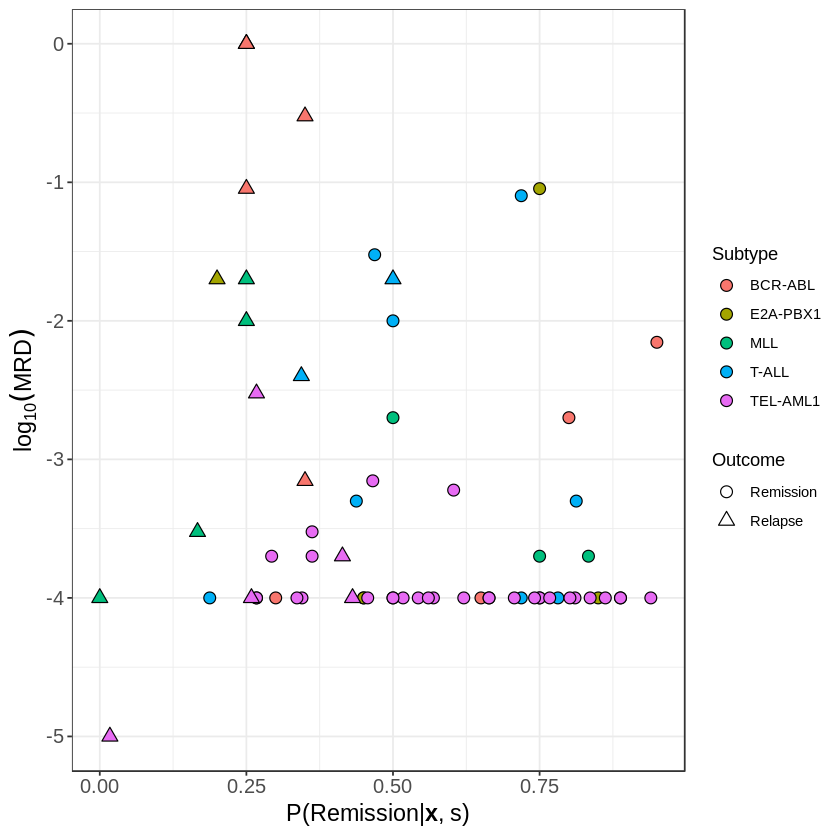

In [44]:
mrd_p_alltrain

In [19]:
# Plot: Jitter - P v.s. Outcome
# Wilcoxon rank sum
list_p <- split(alltrain_features$p, alltrain_features$label)
alltrain_wilcox <- wilcox.test(list_p[[1]], list_p[[2]])
p_label <- sprintf("Wilcoxon rank-sum, p = %.2e", alltrain_wilcox$p.value)

jitter_m1_p_alltrain <- ggplot(
    alltrain_features,
    aes(x = label, y = p_rem, fill = subtype)
  ) +
  geom_point(
    position = position_jitterdodge(
      jitter.width = .7,
      dodge.width = .7
    ),
    size = 3, col = "black", pch = 21
  ) +
  annotate(
    geom = "text",
    x = 1.5, y = 1.1,
    label = p_label
  ) +
  labs(
    fill = "Subtype",
    y = expression(paste('P(Remission|', bold(x), ', s)'))
  ) +
  theme(
    axis.title.x = element_blank(),
    axis.text.x = element_text(size = 12),
    axis.title.y = element_text(size = 14),
    axis.text.y = element_text(size = 12),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )

# WPATH <- "~/Dropbox/temp/m1_wo_mrd-jitter-m1_alltrain.pdf"
# ggsave(WPATH, jitter_m1_p_alltrain, width = 4.8, height = 3)

#### Test set

In [91]:
# p_test_concat <- cbind(
#   p_test2,
#   subtype = yeoh_label[rownames(p_test2), "subtype"],
#   label = factor(
#     yeoh_label[rownames(p_test2), "label"],
#     labels = c("Long-term remission", "Relapse")
#   )
# )

# # Plot: Jitter - P v.s. Outcome
# jitter_m1_test <- ggplot(
#     p_test_concat,
#     aes(x = label, y = p, colour = subtype)
#   ) +
#   geom_point(
#     position = position_jitterdodge(
#       jitter.width = .6,
#       dodge.width = .6
#     )
#   ) +
#   labs(
#     colour = "Subtype",
#     y = expression(paste('P(Remission|', bold(x), ')'))
#   ) +
#   theme(
#     axis.title.x = element_blank(),
#     legend.title = element_text(size = 8),
#     legend.text = element_text(size = 8)
#   )

In [92]:
# WPATH <- "~/Dropbox/temp/jitter-m1_test.pdf"
# ggsave(WPATH, jitter_m1_test, width = 4.5, height = 3)

In [90]:
# # False omission rate
# PN <- sum(p_alltrain_concat$log_mrd <= -4)
# FN <- sum(p_alltrain_concat$label[p_alltrain_concat$log_mrd <= -4] == "Relapse")
# print(FN/PN)
# print(FN)

## Survival analysis

In [45]:
# Remove patients with NA MRD
yeoh_label1 <- na.omit(yeoh_label)
yeoh_label1$d33_mrd_risk <- droplevels(yeoh_label1$d33_mrd_risk)
# Reverse levels
yeoh_label1$d33_mrd_risk <- factor(
  yeoh_label1$d33_mrd_risk,
  levels = rev(levels(yeoh_label1$d33_mrd_risk))
)

### All train set

In [46]:
ssm_p_alltrain <- m1_p_alltrain

### Subset alltrain set
surv_alltrain <- yeoh_label1[unique(substring(sid_alltrain, 1, 4)), ]
# Discretise p(remission|x)
ssm_risk <- character(nrow(ssm_p_alltrain))
ssm_risk[ssm_p_alltrain > 0.5] <- "SR"
ssm_risk[ssm_p_alltrain <= 0.5] <- "IR"
ssm_risk[ssm_p_alltrain <= 0.25] <- "HR"
ssm_risk <- as.factor(ssm_risk)
ssm_risk <- factor(ssm_risk, levels = rev(levels(ssm_risk))) # Reverse levels
names(ssm_risk) <- rownames(ssm_p_alltrain)
print(ssm_risk)

# Join table and vector with different pid ordering
surv_alltrain1 <- merge(surv_alltrain, ssm_risk, by = "row.names")

P053 P054 P055 P056 P057 P134 P152 P170 P175 P184 P049 P050 P051 P102 P145 P161 
  SR   SR   IR   IR   HR   HR   IR   SR   IR   HR   IR   SR   SR   HR   IR   SR 
P058 P122 P131 P137 P160 P167 P211 P001 P004 P005 P007 P008 P010 P012 P103 P116 
  IR   HR   HR   HR   SR   HR   SR   SR   SR   SR   IR   SR   HR   IR   IR   IR 
P151 P013 P014 P015 P016 P017 P018 P019 P022 P023 P024 P025 P026 P027 P028 P029 
  IR   SR   SR   IR   IR   SR   IR   IR   IR   IR   IR   SR   IR   SR   IR   IR 
P031 P032 P033 P034 P035 P036 P094 P099 P106 P120 P121 P127 P135 P136 P147 P156 
  SR   IR   SR   IR   SR   IR   HR   SR   SR   SR   SR   SR   SR   IR   SR   SR 
P165 P166 P172 
  SR   SR   SR 
Levels: SR IR HR


#### Kaplan-Meier model: SSM

In [27]:
km_alltrain_ssm <- survfit(
  Surv(years, event_code != 0) ~ y,
  data = surv_alltrain1
)

# Log-rank test
alltrain_logrank <- survdiff(
  Surv(years, event_code != 0) ~ y,
  data = surv_alltrain1
)
# p-value
alltrain_pval <- pchisq(
  alltrain_logrank$chisq,
  length(alltrain_logrank$n) - 1,
  lower.tail = F
)

# # Plot: Kaplan-Meier
WPATH <- "~/Dropbox/temp/m1_wo_mrd-km_alltrain-ssm.pdf"
pdf(WPATH, width = 4.5, height = 5)

COL <- ggplot_palette(3)
plot(
  km_alltrain_ssm, col= COL, las = 1, lwd = 2, mark.time = T,
  xlab = "Years", ylab = "Event-free survival probability"
)
legend(
  x = 4, y = .45, col = COL,
  legend = c(
    "SSM Standard Risk",
    "SSM Intermediate Risk",
    "SSM High Risk"
  ),
  bg = "white", lwd = 2, lty = 1, cex = 0.8
)
text(
  x = 7, y = .85,
  sprintf("Log-rank, p = %.2e", alltrain_pval)
)

dev.off()

png 
  2

In [28]:
# 5 year EFS
summary(km_alltrain_ssm, times = 5)
# Log-rank test
alltrain_logrank <- survdiff(
  Surv(years, event_code != 0) ~ y,
  data = surv_alltrain1
)
# Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ y, data = surv_alltrain1)

                y=SR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
           5           18            0            1            0            1 
upper 95% CI 
           1 

                y=IR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000        7.000        4.000        0.772        0.102        0.596 
upper 95% CI 
       1.000 

                y=HR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000        8.000       13.000        0.409        0.105        0.248 
upper 95% CI 
       0.676 


#### Kaplan-Meier model: MRD

In [29]:
km_alltrain_mrd <- survfit(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_alltrain1
)

# Log-rank test
alltrain_mrd_logrank <- survdiff(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_alltrain1
)
# p-value
alltrain_mrd_pval <- pchisq(
  alltrain_mrd_logrank$chisq,
  length(alltrain_mrd_logrank$n) - 1,
  lower.tail = F
)

# Plot: Kaplan-Meier
WPATH <- "~/Dropbox/temp/m1_wo_mrd-km_alltrain-mrd.pdf"
pdf(WPATH, width = 4.5, height = 5)

COL <- ggplot_palette(3)
plot(
  km_alltrain_mrd, col= COL, las = 1, lwd = 2, mark.time = T,
  xlab = "Years", ylab = "Event-free survival probability"
)
legend(
  "bottomright", col = COL,
  legend=c(
    "MRD Standard Risk",
    "MRD Intermediate Risk",
    "MRD High Risk"
  ),
  bg = "white", lwd = 2, lty = 1, cex = 0.8
)
text(
  x = 7.5, y = .5,
  sprintf("Log-rank, p = %.2e", alltrain_mrd_pval)
)

dev.off()

png 
  2

In [30]:
# 5 year EFS
summary(km_alltrain_mrd, times = 5)
# Log-rank test
survdiff(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_alltrain1
)
# Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_alltrain1)

                d33_mrd_risk=Standard 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      5.0000      23.0000       4.0000       0.8917       0.0512       0.7969 
upper 95% CI 
      0.9979 

                d33_mrd_risk=Intermediate 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000        7.000        5.000        0.680        0.122        0.479 
upper 95% CI 
       0.965 

                d33_mrd_risk=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000        3.000        8.000        0.333        0.136        0.150 
upper 95% CI 
       0.742 


Call:
survdiff(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_alltrain1)

                           N Observed Expected (O-E)^2/E (O-E)^2/V
d33_mrd_risk=Standard     38        4    10.43    3.9633    10.417
d33_mrd_risk=Intermediate 17        5     4.43    0.0738     0.101
d33_mrd_risk=High         12        8     2.14   16.0115    18.798

 Chisq= 20.6  on 2 degrees of freedom, p= 3e-05 

### Test set

In [45]:
ssm_p_test <- m1_p_test

# Subset test set
surv_test <- yeoh_label1[unique(substring(sid_test, 1, 4)), ]
# Discretise p(remission|x)
p_test_cat <- character(nrow(ssm_p_test))
p_test_cat[ssm_p_test > 0.5] <- "SR"
p_test_cat[ssm_p_test <= 0.5] <- "IR"
p_test_cat[ssm_p_test <= 0.25] <- "HR"
p_test_cat <- as.factor(p_test_cat)
names(p_test_cat) <- rownames(ssm_p_test)
# Reverse levels
p_test_cat1 <- factor(p_test_cat, levels = rev(levels(p_test_cat)))
print(p_test_cat1)
# Join table and vector with different pid ordering
surv_test1 <- merge(surv_test, p_test_cat1, by = "row.names")

P175 P102 P145 P161 P131 P137 P211 P103 P151 P099 P106 P120 P121 P127 P135 P136 
  SR   HR   IR   SR   HR   IR   SR   IR   SR   SR   SR   SR   IR   SR   SR   IR 
P147 P156 P166 
  SR   SR   SR 
Levels: SR IR HR


#### Kaplan-Meier model: SSM

In [169]:
# EFS - 0 v.s. 1 & 2
km_test_ssm <- survfit(
  Surv(years, event_code != 0) ~ y,
  data = surv_test1
)

# Plot: Kaplan-Meier
WPATH <- "~/Dropbox/temp/km_test-ssm.pdf"
pdf(WPATH, width = 5, height = 5.5)

COL <- ggplot_palette(3)
plot(
  km_test_ssm, col= COL, las = 1, lwd = 2, mark.time = T,
  xlab = "Years", ylab = "Event-free survival probability"
)
legend(
  "bottomright", col = COL,
  legend = c(
    "SSM Standard Risk",
    "SSM Intermediate Risk",
    "SSM High Risk"
  ),
  bg = "white", lwd = 2, lty = 1, cex = 0.8
)

dev.off()

png 
  2

In [886]:
# 5 year EFS
summary(km_test_ssm, times = 3)
# Log-rank test
survdiff(
  Surv(years, event_code != 0) ~ ssm_risk,
  data = surv_test1
)
# Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ p_cat3, data = surv_test)

                p_cat3=SR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       7.0000       1.0000       0.9091       0.0867       0.7541 
upper 95% CI 
      1.0000 

                p_cat3=IR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
           3            3            0            1            0            1 
upper 95% CI 
           1 

                p_cat3=HR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       1.0000       4.0000       0.2000       0.1789       0.0346 
upper 95% CI 
      1.0000 


Call:
survdiff(formula = Surv(years, event_code != 0) ~ p_cat3, data = surv_test)

           N Observed Expected (O-E)^2/E (O-E)^2/V
p_cat3=SR 11        1    2.995     1.329      3.33
p_cat3=IR  3        0    0.926     0.926      1.14
p_cat3=HR  5        4    1.078     7.917     10.20

 Chisq= 10.3  on 2 degrees of freedom, p= 0.006 

#### Kaplan-Meier model: MRD

In [170]:
# EFS - 0 v.s. 1 & 2
km_test_mrd <- survfit(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_test1
)

# Plot: Kaplan-Meier
WPATH <- "~/Dropbox/temp/km_test-mrd.pdf"
pdf(WPATH, width = 5, height = 5.5)

COL <- ggplot_palette(3)
plot(
  km_test_mrd, col= COL, las = 1, lwd = 2, mark.time = T,
  xlab = "Years", ylab = "Event-free survival probability"
)
legend(
  "bottomright", col = COL,
  legend=c(
    "MRD Standard Risk",
    "MRD Intermediate risk",
    "MRD High Risk"
  ),
  bg = "white", lwd = 2, lty = 1, cex = 0.8
)

dev.off()

png 
  2

In [103]:
# 5 year EFS
summary(km_test_mrd, times = 3)
# Log-rank test
survdiff(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_test1
)
# Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_test1)

                d33_mrd_risk=Standard 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       9.0000       1.0000       0.9167       0.0798       0.7729 
upper 95% CI 
      1.0000 

                d33_mrd_risk=Intermediate 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       3.000        1.000        1.000        0.667        0.272        0.300 
upper 95% CI 
       1.000 

                d33_mrd_risk=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       1.0000       3.0000       0.2500       0.2165       0.0458 
upper 95% CI 
      1.0000 


Call:
survdiff(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_test1)

                           N Observed Expected (O-E)^2/E (O-E)^2/V
d33_mrd_risk=Standard     12        1    3.304   1.60684   4.75922
d33_mrd_risk=Intermediate  3        1    0.926   0.00586   0.00721
d33_mrd_risk=High          4        3    0.769   6.46605   7.78223

 Chisq= 8.2  on 2 degrees of freedom, p= 0.02 

#### Kaplan-Meier: Stratify by MRD

In [91]:
# # Stratify into separate MRD categories and plot KM
# idx_hr <- surv_test1$d33_mrd_risk != "Standard"
# surv_hr <- surv_test1[idx_hr, ]
# surv_sr <- surv_test1[!idx_hr, ]

# km_hr <- survfit(
#   Surv(years, event_code != 0) ~ ssm_risk,
#   data = surv_hr 
# )
# # # Plot: Kaplan-Meier
# # WPATH <- "~/Dropbox/temp/km-mrd_test.pdf"
# # pdf(WPATH, width = 5, height = 5.5)

# COL <- ggplot_palette(3)
# plot(
#   km_hr, col= COL, las = 1, lwd = 2,
#   xlab = "Years", ylab = "Event-free survival probability"
# )
# legend(
#   "bottomright", col = COL,
#   legend = c(
#     "SSM Standard Risk",
#     "SSM Intermediate risk",
#     "SSM High Risk"
#   ),
#   bg = "white", lwd = 2, lty = 1, cex = 0.8
# )

# # dev.off()

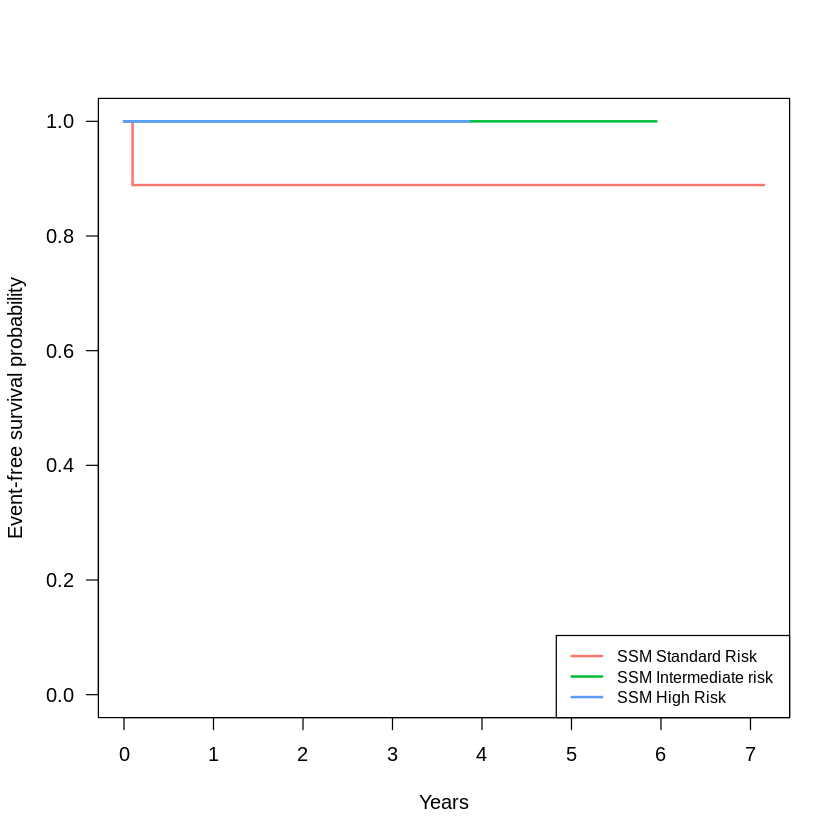

In [90]:
# km_sr <- survfit(
#   Surv(years, event_code != 0) ~ ssm_risk,
#   data = surv_sr
# )
# # # Plot: Kaplan-Meier
# # WPATH <- "~/Dropbox/temp/km-mrd_test.pdf"
# # pdf(WPATH, width = 5, height = 5.5)

# COL <- ggplot_palette(3)
# plot(
#   km_sr, col= COL, las = 1, lwd = 2,
#   xlab = "Years", ylab = "Event-free survival probability"
# )
# legend(
#   "bottomright", col = COL,
#   legend = c(
#     "SSM Standard Risk",
#     "SSM Intermediate risk",
#     "SSM High Risk"
#   ),
#   bg = "white", lwd = 2, lty = 1, cex = 0.8
# )

# # dev.off()

### Cox PH model
- Coefficients and HRs are extremely large
- Due to standard risk having no events at all

In [93]:
# multi_cox <- coxph(
#   Surv(years, event_code != 0) ~ p_cat1,
#   data = surv_alltrain
# )
# summary(multi_cox)

In [92]:
# multi_cox <- coxph(
#   Surv(years, event_code != 0) ~ d33_mrd_risk,
#   data = surv_alltrain
# )
# summary(multi_cox)

In [701]:
# # Check: Linearity assumption
# plot(predict(multi_cox), residuals(multi_cox, type = "martingale"))
# lines(smooth.spline(predict(multi_cox),
#                     residuals(multi_cox, type = "deviance")))

# # Check: Proportional hazards assumption
# plot(cox.zph(multi_cox)[1])

In [688]:
# Multivariate Fine and Gray
# Adjust for subtype, NCI risk criteria
# bmtcrrMat <- model.matrix(object = ~ D + Age + Sex + Phase + Source, data = bmtcrr)

# bmtcrrMat <- bmtcrrMat[,-1]
# head(bmtcrrMat)
# resCrrRel <- crr(ftime    = bmtcrr$ftime, # vector of failure/censoring times
#                  fstatus  = bmtcrr$Status, # vector with a unique code for each failure type and censoring
#                  cov1     = bmtcrrMat, #  matrix (nobs x ncovs) of fixed covariates
#                  ## cov2     = , # matrix of covariates that will be multiplied by functions of time
#                  ## tf       = , # functions of time
#                  ## cengroup = , # vector with different values for each group with a distinct censoring distribution
#                  failcode = "Relapse", # code of fstatus that denotes the failure type of interest
#                  cencode  = "Censored" # code of fstatus that denotes censored observations
#                  )
# summary(resCrrRel)

## Table of pAUC values (FPR = 0, 0.2)

In [126]:
# Metadata of table pAUC values
# Remission samples lie on the FPR
roc_metadata <- t(sapply(
  list_X_y,
  function(X) table(yeoh_label[rownames(X), "label"])
))
rownames(roc_metadata) <- subtypes
print(roc_metadata)

              0  1
BCR-ABL       5  5
E2A-PBX1      5  1
Hyperdiploid 31  4
MLL           3  4
Others       63 20
T-ALL         8  2
TEL-AML1     29  5


In [100]:
feats <- c(
  "angle_d0d8_d0normal", "erm1_ratio2", "l2norm_ratio2",
  "log_mrd", "p_rem", "global_erm"
)

list_rocs <- lapply(
  list_X_y,
  plot_roc,
  response = "label",
  predictor = feats,
  pauc.limits = c(1, 0.8),
  pauc.axis = "specificity",
  return.auc = T,
)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Sett

In [101]:
list_rocplots <- lapply(list_rocs, function(obj) obj$plot)
list_aucs <- lapply(list_rocs, function(obj) obj$auc)

In [453]:
# for (i in seq_along(list_rocplots)) {
#   wpath <- sprintf("~/Dropbox/temp/roc-%s.pdf", subtypes[i])
#   print(wpath)
#   ggsave(wpath, list_rocplots[[i]], width = 6, height = 6)
# }

[1] "~/Dropbox/temp/roc-BCR-ABL.pdf"
[1] "~/Dropbox/temp/roc-E2A-PBX1.pdf"
[1] "~/Dropbox/temp/roc-Hyperdiploid.pdf"
[1] "~/Dropbox/temp/roc-MLL.pdf"
[1] "~/Dropbox/temp/roc-Others.pdf"
[1] "~/Dropbox/temp/roc-T-ALL.pdf"
[1] "~/Dropbox/temp/roc-TEL-AML1.pdf"


In [107]:
names(list_aucs) <- subtypes
auc_tab <- do.call(rbind, list_aucs)
print(auc_tab[, c(5,4,6)])
print(xtable(auc_tab[, c(5,4,6)], digits = 3))

                 p_rem   log_mrd global_erm
BCR-ABL      0.7777778 0.8888889         NA
E2A-PBX1     1.0000000        NA  1.0000000
Hyperdiploid 0.6330645 0.7222222  0.6102151
MLL          1.0000000 0.7222222  0.5833333
Others       0.5017637 0.6710317  0.5194004
T-ALL        0.7395833        NA         NA
TEL-AML1     0.7394636 0.5905492  0.6628352
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Fri Mar 12 15:18:47 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & p\_rem & log\_mrd & global\_erm \\ 
  \hline
BCR-ABL & 0.778 & 0.889 &  \\ 
  E2A-PBX1 & 1.000 &  & 1.000 \\ 
  Hyperdiploid & 0.633 & 0.722 & 0.610 \\ 
  MLL & 1.000 & 0.722 & 0.583 \\ 
  Others & 0.502 & 0.671 & 0.519 \\ 
  T-ALL & 0.740 &  &  \\ 
  TEL-AML1 & 0.739 & 0.591 & 0.663 \\ 
   \hline
\end{tabular}
\end{table}


### Test data (w Hyper, Others)

In [454]:
# Concatenate global ERM to X_y
# OPTION: list_obj1 created with variant function predict_plot
list_X_y <- lapply(
  list_obj,
  function(obj, global_erm) {
    cbind(obj$X_y,
          global_erm = global_erm[rownames(obj$X_y), ])
  },
  global_erm_test1
)

In [519]:
list_boxplots <- lapply(list_X_y, plot_boxplot)
for (i in seq_len(length(subtypes))) {
  wpath <- sprintf("~/Dropbox/temp/features_test-%s.pdf",
                   subtypes[i])
  ggsave(wpath, list_boxplots[[i]],
         width = 10, height = 3)
}

                feature    value       lab
log_mrd    log[10](MRD) -4.00000 p = 0.097
global_erm 'Global ERM' 56.07634 p = 0.815
                                       feature    value       lab
log_mrd                           log[10](MRD) -5.00000 p = 0.161
global_erm                        'Global ERM' 87.29912 p = 0.176
p_rem      paste('P(Remission|', bold(x), ')')  0.92500 p = 0.369
                                       feature      value       lab
log_mrd                           log[10](MRD) -5.0000000 p = 0.004
global_erm                        'Global ERM' 98.3373024 p = 0.271
p_rem      paste('P(Remission|', bold(x), ')')  0.8076923 p = 0.679


In [686]:
subtype <- subtypes[[1]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[
  , Y[colnames(raw_delta_D0N), "subtype"] == subtype
]
raw_delta_D0D8_1 <- raw_delta_D0D8[
  , Y[colnames(raw_delta_D0D8), "subtype"] == subtype
]

stopifnot(substring(colnames(raw_delta_D0N_1),1,4) ==
          substring(colnames(raw_delta_D0D8_1),1,4))

mu_delta <- apply(raw_delta_D0N_1, 1, mean)
var_delta <- apply(raw_delta_D0N_1, 1, var)
# plot(mu_delta, var_delta)
THRESHOLD <- 3
idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]
print(length(idx_subnetwork))

## Selecting subnetworks with significant dysregulation
raw_delta_D0D8_2 <- raw_delta_D0D8_1[idx_subnetwork, ]
raw_delta_D0N_2 <- raw_delta_D0N_1[idx_subnetwork, ]

# print(colnames(delta_D0D8_1)[
#   Y[colnames(delta_D0D8_1), "label"] == 1
# ])

pct_delta <- raw_delta_D0D8_2 / raw_delta_D0N_2
pct_delta1 <- colMeans(raw_delta_D0D8_2) / colMeans(raw_delta_D0N_2)

[1] "BCR-ABL"
[1] 90


In [386]:
subtype <- subtypes[[2]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[, Y[colnames(raw_delta_D0N), "subtype"] == subtype]
raw_delta_D0D8_1 <- raw_delta_D0D8[, Y[colnames(raw_delta_D0D8), "subtype"] == subtype]

stopifnot(substring(colnames(delta_D0N_1),1,4) ==
          substring(colnames(delta_D0D8_1),1,4))

# pct_delta <- delta_D0D8_1 / delta_D0N_1
# print(Y[colnames(pct_delta), "label"])
# plot(pct_delta, col = Y[names(pct_delta), "label"] + 1)

[1] "E2A-PBX1"


## Contingency table

### Data set: All train

#### SSM w/ MRD

In [84]:
### Subset alltrain set
surv_alltrain <- yeoh_label1[unique(substring(sid_alltrain, 1, 4)), ]

## SSM w/ MRD
ssm_p_alltrain <- m1_p_alltrain
# Discretise p(remission|x)
ssm_risk <- character(nrow(ssm_p_alltrain))
ssm_risk[ssm_p_alltrain > 0.5] <- "SR"
ssm_risk[ssm_p_alltrain <= 0.5] <- "IR"
ssm_risk[ssm_p_alltrain <= 0.25] <- "HR"
ssm_risk <- as.factor(ssm_risk)
ssm_risk <- factor(ssm_risk, levels = rev(levels(ssm_risk))) # Reverse levels
names(ssm_risk) <- rownames(ssm_p_alltrain)

## SSM w/o MRD
ssm_p1_alltrain <- m1a_p_alltrain
# Discretise p(remission|x)
ssm_risk1 <- character(nrow(ssm_p1_alltrain))
ssm_risk1[ssm_p1_alltrain > 0.5] <- "SR"
ssm_risk1[ssm_p1_alltrain <= 0.5] <- "IR"
ssm_risk1[ssm_p1_alltrain <= 0.25] <- "HR"
ssm_risk1 <- as.factor(ssm_risk1)
ssm_risk1 <- factor(ssm_risk1, levels = rev(levels(ssm_risk1))) # Reverse levels
names(ssm_risk1) <- rownames(ssm_p1_alltrain)

# Join table and vector with different pid ordering
surv_alltrain1 <- cbind(
  surv_alltrain,
  ssm_risk = ssm_risk[rownames(surv_alltrain)]
)
surv_alltrain2 <- cbind(
  surv_alltrain1,
  ssm_womrd_risk = ssm_risk1[rownames(surv_alltrain1)]
)
head(surv_alltrain2)

,d33_mrd,d33_mrd_risk,Status,event_code,label,years,training_test,subtype,ssm_risk,ssm_womrd_risk
,<dbl>,<fct>,<fct>,<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>
P001,5e-04,Intermediate,CCR,0,0,3.264,Training set,T-ALL,SR,SR
P004,8e-02,High,CCR,0,0,9.766,Training set,T-ALL,SR,SR
P005,1e-04,Standard,CCR,0,0,9.506,Training set,T-ALL,SR,SR
P007,4e-03,Intermediate,Relapse (Induction),1,1,0.003,Training set,T-ALL,IR,HR
P008,1e-04,Standard,CCR,0,0,8.446,Training set,T-ALL,SR,SR
P010,1e-04,Standard,CCR,0,0,10.525,Training set,T-ALL,HR,HR


In [98]:
# Replace SSM w/o MRD: IR with SSM w/ MRD predictions
# SSM Strategy
ssm_strategy <- surv_alltrain2$ssm_womrd_risk
idx_ihrisk <- ssm_strategy %in% c("IR", "HR")
ssm_strategy[idx_ihrisk] <- surv_alltrain2$ssm_risk[idx_ihrisk]
surv_alltrain2$ssm_strategy <- ssm_strategy

In [100]:
table(surv_alltrain2$ssm_strategy, surv_alltrain2$label)

    
      0  1
  SR 31  0
  IR 18  8
  HR  1  9

In [107]:
print(surv_alltrain2[9:11])

     ssm_risk ssm_womrd_risk ssm_strategy
P001       SR             SR           SR
P004       SR             SR           SR
P005       SR             SR           SR
P007       IR             HR           IR
P008       SR             SR           SR
P010       HR             HR           HR
P012       IR             IR           IR
P013       SR             IR           SR
P014       SR             IR           SR
P015       IR             IR           IR
P016       IR             HR           IR
P017       SR             SR           SR
P018       IR             HR           IR
P019       IR             HR           IR
P022       IR             HR           IR
P023       IR             HR           IR
P024       IR             IR           IR
P025       SR             SR           SR
P026       IR             HR           IR
P027       SR             SR           SR
P028       IR             HR           IR
P029       IR             IR           IR
P031       SR             SR      

#### Accuracy, Sensitivity, Specificity (with negative scoring)

In [101]:
#' @y_pred factor vector of prediction labels in {"SR", "IR", "HR"}
#' @param y_true truth labels represented by 0, 1
# +1 for correct predictions, -1 for wrong predictions
# Assumption: No intermediate risk
calc_neg_accuracy <- function(y_true, y_pred, verbose = F) {
  y_pred_sub <- y_pred[y_pred != "IR"]
  y_true_sub <- y_true[y_pred != "IR"]
  y_pred_sub <- ifelse(y_pred_sub == "HR", 1, 0)
  if (verbose)
    print(cbind(y_pred_sub, y_true_sub))
  
  sum(ifelse(y_true_sub == y_pred_sub, 1, -1)) / length(y_true)
}
#' @y_pred factor vector of prediction labels in {"SR", "IR", "HR"}
#' @param y_true truth labels represented by 0, 1
# +1 for correct predictions, -1 for wrong predictions
# Assumption: No intermediate risk
calc_neg_sensitivity <- function(y_true, y_pred, verbose = F) {
  ap <- y_true[y_true == 1]
  y_pred_sub <- y_pred[y_true == 1]
  y_pred_sub1 <- y_pred_sub[y_pred_sub != "IR"]
  ap_sub <- ap[y_pred_sub != "IR"]
  y_pred_sub1 <- ifelse(y_pred_sub1 == "HR", 1, 0)
  if (verbose)
    print(cbind(ap_sub, y_pred_sub1))
  sum(ifelse(ap_sub == y_pred_sub1, 1, -1)) / length(ap)
}
#' @y_pred factor vector of prediction labels in {"SR", "IR", "HR"}
#' @param y_true truth labels represented by 0, 1
# +1 for correct predictions, -1 for wrong predictions
# Assumption: No intermediate risk
calc_neg_specificity <- function(y_true, y_pred, verbose = F) {
  an <- y_true[y_true == 0]
  y_pred_sub <- y_pred[y_true == 0]
  y_pred_sub1 <- y_pred_sub[y_pred_sub != "IR"]
  an_sub <- an[y_pred_sub != "IR"]
  y_pred_sub1 <- ifelse(y_pred_sub1 == "HR", 1, 0)
  if (verbose)
    print(cbind(an_sub, y_pred_sub1))
  sum(ifelse(an_sub == y_pred_sub1, 1, -1)) / length(an)
}

In [104]:
calc_neg_accuracy(surv_alltrain2$label, surv_alltrain2$ssm_risk)
calc_neg_sensitivity(surv_alltrain2$label, surv_alltrain2$ssm_risk)
calc_neg_specificity(surv_alltrain2$label, surv_alltrain2$ssm_risk)

[1] 0.5820896

[1] 0.5294118

[1] 0.6

In [30]:
mrd_risk <- factor(
  surv_alltrain1$d33_mrd_risk,
  labels = c("SR", "IR", "HR")
)
calc_neg_accuracy(surv_alltrain1$label, mrd_risk)
calc_neg_sensitivity(surv_alltrain1$label, mrd_risk)
calc_neg_specificity(surv_alltrain1$label, mrd_risk)

[1] 0.5074627

[1] 0.2352941

[1] 0.6

## Finding classification threshold

In [436]:
# Calculate threshold that maximises recall and specificity
# for global ERM predictions
#' @param X_train dataframe of global ERM features of training set
#' @param X_test dataframe of global ERM features of test set
#' @param metadata dataframe of metadata with pid as rownames (yeoh_label)
argmax_threshold <- function(X_train, metadata) {
  X_train_y <- data.frame(
    X_train,
    label = metadata[rownames(X_train), "label"]
  )

  roc_obj <- pROC::roc(X_train_y, "label", "erm1", direction = ">")
  # NOTE: roc function calculates thresholds by taking the 
  # arithmetic mean of two adjacent points
  roc_thresholds <- data.frame(
    roc_obj$thresholds,
    roc_obj$sensitivities,
    roc_obj$specificities
  )
  roc_thresholds$mean <- mapply(
    function(x, y) mean(c(x, y)),
    roc_obj$sensitivities,
    roc_obj$specificities
  )

  threshold <- roc_thresholds[
    which.max(roc_thresholds$mean), "roc_obj.thresholds"
  ]
  
  threshold
}

#' @return dataframe of original test set features concatenated with
#' predictions based on threshold
predict_test <- function(X_test, threshold, metadata) {
  data.frame(
    X_test,
    label = metadata[rownames(X_test), "label"],
    y_pred = ifelse(X_test$erm1 < threshold, 1, 0)
  )  
}

threshold <- argmax_threshold(global_erm_train1, yeoh_label)
global_erm_test1_all <- predict_test(global_erm_test1, threshold, yeoh_label)
recall <- calc_recall(global_erm_test1_all$label, global_erm_test1_all$y_pred)
specificity <- calc_specificity(global_erm_test1_all$label, global_erm_test1_all$y_pred)

Setting levels: control = 0, case = 1


[1] 53.4722
[1] 0.875
[1] 0.4683544


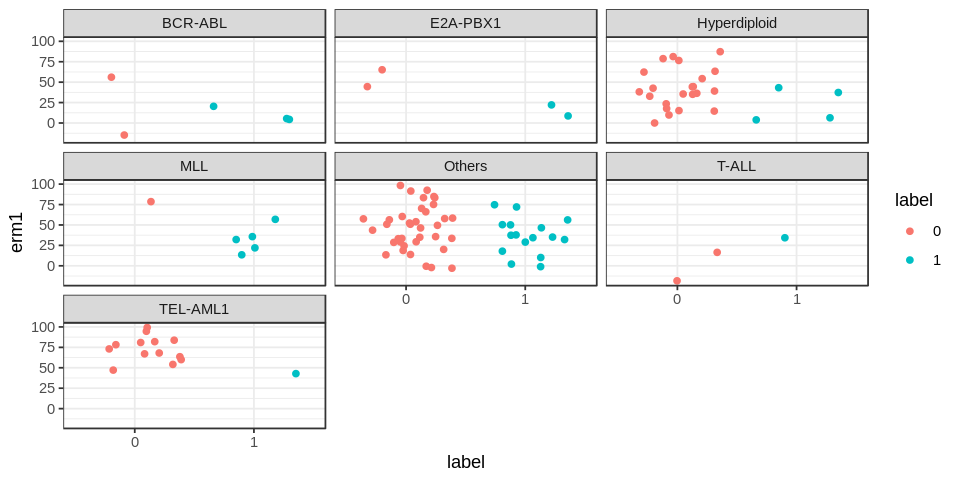

In [441]:
print(threshold)
print(recall)
print(specificity)
global_erm_test1_all2 <- global_erm_test1_all
global_erm_test1_all2$label <- as.factor(global_erm_test1_all2$label)
global_erm_test1_all2$subtype <- yeoh_label[
  rownames(global_erm_test1_all2), "subtype"
]

ggplot(global_erm_test1_all2,
       aes(label, erm1, colour = label)) +
  geom_point(position = position_jitter()) +
  facet_wrap(~subtype)

In [378]:
# Calculate threshold that maximises recall and specificity
# class(yeoh_label[rownames(global_erm_train2), "label"])
global_erm_train2_y <- data.frame(
  global_erm_train2,
  label = yeoh_label[rownames(global_erm_train2), "label"]
)

roc_obj <- pROC::roc(
  global_erm_train2_y,
  "label",
  "erm1",
  direction = ">"
)
# NOTE: roc function calculates thresholds by taking the 
# arithmetic mean of two adjacent points
roc_thresholds <- data.frame(
  roc_obj$thresholds,
  roc_obj$sensitivities,
  roc_obj$specificities
)
roc_thresholds$mean <- mapply(
  function(x, y) mean(c(x, y)),
  roc_obj$sensitivities,
  roc_obj$specificities
)

Setting levels: control = 0, case = 1


In [395]:
threshold <- roc_thresholds[which.max(roc_thresholds$mean), "roc_obj.thresholds"]

global_erm_test2_all <- data.frame(
  global_erm_test2,
  label = yeoh_label[rownames(global_erm_test2), "label"],
  y_pred = ifelse(global_erm_test2$erm1 < threshold, 1, 0)
)

global_erm_test2_recall <- calc_recall(
  global_erm_test2_all$label,
  global_erm_test2_all$y_pred
)
global_erm_test2_specificity <- calc_specificity(
  global_erm_test2_all$label,
  global_erm_test2_all$y_pred
)
print(global_erm_test2_recall)
print(global_erm_test2_specificity)

[1] 0.9166667
[1] 0.8


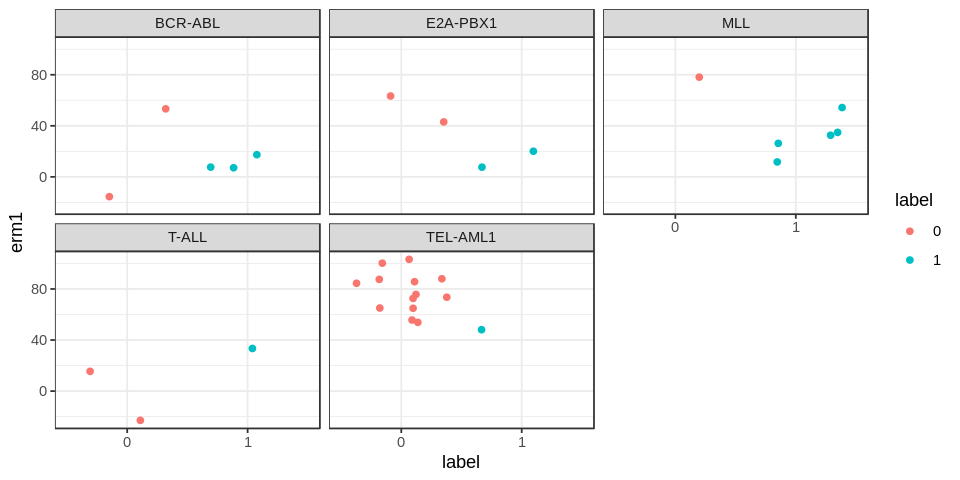

In [443]:
global_erm_test2_all2 <- global_erm_test2_all
global_erm_test2_all2$label <- as.factor(global_erm_test2_all2$label)
global_erm_test2_all2$subtype <- yeoh_label[
  rownames(global_erm_test2_all2), "subtype"
]

ggplot(global_erm_test2_all2,
       aes(label, erm1, colour = label)) +
  geom_point(position = position_jitter()) +
  facet_wrap(~subtype)